In [1]:
import functools
import os
import typing

import joblib
import networkx as nx
import numpy as np
import pandas as pd
import dcor
from scipy.stats import pearsonr, ttest_rel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from tqdm.auto import tqdm
from scipy import stats

e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


In [3]:
def graph_nodes_representation(graph, nodelist):
    """
    Create an alternative representation of a graph which is hashable
    and equivalent graphs have the same hash.

    Python cannot PROPERLY use nx.Graph/DiGraph as key for
    dictionaries, because two equivalent graphs with just different
    order of the nodes would result in different keys. This is
    undesirable here.

    So here we transform the graph into an equivalent form that is
    based on a specific nodelist and that is hashable. In this way,
    two equivalent graphs, once transformed, will result in identical
    keys.

    So we use the following trick: extract the adjacency matrix
    (with nodes in a fixed order) and then make a hashable thing out
    of it, through tuple(array.flatten()):
    """

    # This get the adjacency matrix with nodes in a given order, as
    # numpy array (which is not hashable):
    adjacency_matrix = nx.adjacency_matrix(graph, nodelist=nodelist).todense()

    # This transforms the numpy array into a hashable object:
    hashable = tuple(adjacency_matrix.flatten())

    return hashable

def create_graph_label():
    """
    Create a dictionary from graphs to labels, in two formats.
    """
    graph_label = {
        nx.DiGraph([("X", "Y"), ("v", "X"), ("v", "Y")]): "Confounder",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("Y", "v")]): "Collider",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("v", "Y")]): "Mediator",
        nx.DiGraph([("X", "Y"), ("v", "X")]):             "Cause of X",
        nx.DiGraph([("X", "Y"), ("v", "Y")]):             "Cause of Y",
        nx.DiGraph([("X", "Y"), ("X", "v")]):             "Consequence of X",
        nx.DiGraph([("X", "Y"), ("Y", "v")]):             "Consequence of Y",
        nx.DiGraph({"X": ["Y"], "v": []}):                "Independent",
    }

    nodelist = ["v", "X", "Y"]

    # This is an equivalent alternative to graph_label but in a form
    # for which two equivalent graphs have the same key:
    adjacency_label = {
        graph_nodes_representation(graph, nodelist): label
        for graph, label in graph_label.items()
    }

    return graph_label, adjacency_label

def get_labels(adjacency_matrix, adjacency_label):
    """
    Transform an adjacency_matrix (as pd.DataFrame) into a dictionary of variable:label
    """

    result = {}
    for variable in adjacency_matrix.columns.drop(["X", "Y"]):
        submatrix = adjacency_matrix.loc[[variable, "X", "Y"], [variable, "X", "Y"]]  # this is not hashable
        key = tuple(submatrix.values.flatten())  # this is hashable and a compatible with adjacency_label
    
        result[variable] = adjacency_label[key]

    return result

graph_label, adjacency_label = create_graph_label()

In [4]:
X_train, y_train, X_test = crunch.load_data()

download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


In [5]:
def pearson_correlation(dataset):
    """
    Given a dataset, we compute the correlation-based features for each
    varibale, which are the correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs
    of correlations.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = dataset.corr().drop([variable], axis="columns").loc[variable].abs()

        df.append({
            "variable": variable,
            "corr(v,X)": dataset[[variable, "X"]].corr().loc[variable, "X"],
            "corr(v,Y)": dataset[[variable, "Y"]].corr().loc[variable, "Y"],
            "max(corr(v, others))": tmp.max(),
            "min(corr(v, others))": tmp.min(),
            "mean(corr(v, others))": tmp.mean(),
            "std(corr(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["corr(X,Y)"] = dataset[["X", "Y"]].corr().loc["X", "Y"]

    # pearsonr is NaN when the variance is 0, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def ttest(dataset, pvalue_threshold=0.05):
    """
    Given a dataset, this function computes the t-test between the
    values each variable v and X, Y. The t value and the result of the
    t-test with a given pvalue_threshold, are used to create features
    to describe/embed v, as well as the t-test result between the
    values of X and Y.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        ttest_vX = ttest_rel(dataset[variable], dataset["X"])
        ttest_vY = ttest_rel(dataset[variable], dataset["Y"])

        df.append({
            "variable": variable,
            "ttest(v,X)": ttest_vX.statistic,
            f"pvalue(ttest(v,X))<={pvalue_threshold}": (ttest_vX.pvalue <= pvalue_threshold).astype(float),
            "ttest(v,Y)": ttest_vY.statistic,
            f"pvalue(ttest(v,Y))<={pvalue_threshold}": (ttest_vY.pvalue <= pvalue_threshold).astype(float),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    ttest_XY = ttest_rel(dataset["X"], dataset["Y"])
    df["ttest(X,Y)"] = ttest_XY.statistic
    df[f"pvalue(ttest(X,Y))<={pvalue_threshold}"] = (ttest_XY.pvalue <= pvalue_threshold).astype(float)

    # some the ttest returns NaN when the variance is 0, so we fill with 0:
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def mutual_information(dataset):
    """
    Given a dataset, we compute the mutual-information-based features
    for each varibale, which are the correlation between that variable
    X and Y, as well as summary statistics (max, min, mean, std) of
    all pairs of correlations.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = mutual_info_regression(dataset.drop(columns=[variable]), dataset[variable])

        df.append({
            "variable": variable,
            "MI(v,X)": mutual_info_regression(dataset[[variable]], dataset["X"], discrete_features=False)[0],
            "MI(v,Y)": mutual_info_regression(dataset[[variable]], dataset["Y"], discrete_features=False)[0],
            "max(MI(v, others))": tmp.max(),
            "min(MI(v, others))": tmp.min(),
            "mean(MI(v, others))": tmp.mean(),
            "std(MI(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["MI(X,Y)"] = mutual_info_regression(dataset[["X"]], dataset["Y"], discrete_features=False)[0]

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def add_dimension_feature(dataset):
    """
    Add a dimension feature to the dataset.
    """
    variables = dataset.columns.drop(["X", "Y"])
    dimension = len(variables)
    square_dimension = dimension * dimension
    df = pd.DataFrame({
        "variable": variables,
        "dimension": dimension,
        "square_dimension": square_dimension
    })
    df["dataset"] = dataset.name
    
    return df

def spearman_correlation(dataset):
    """
    Given a dataset, we compute the Spearman rank correlation-based features for each
    variable, which are the Spearman correlation between that variable with X and Y,
    as well as the Spearman correlation between X and Y.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        df.append({
            "variable": variable,
            "spearman_corr(v,X)": dataset[[variable, "X"]].corr(method='spearman').loc[variable, "X"],
            "spearman_corr(v,Y)": dataset[[variable, "Y"]].corr(method='spearman').loc[variable, "Y"],
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["spearman_corr(X,Y)"] = dataset[["X", "Y"]].corr(method='spearman').loc["X", "Y"]

    # Spearman correlation is NaN when there are ties in rank, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def kendall_correlation(dataset):
    """
    Given a dataset, we compute the Kendall rank correlation-based features for each
    variable, which are the Kendall correlation between that variable with X and Y,
    as well as the Kendall correlation between X and Y.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        df.append({
            "variable": variable,
            "kendall_corr(v,X)": stats.kendalltau(dataset[variable], dataset["X"])[0],
            "kendall_corr(v,Y)": stats.kendalltau(dataset[variable], dataset["Y"])[0],
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["kendall_corr(X,Y)"] = stats.kendalltau(dataset["X"], dataset["Y"])[0]

    # Kendall correlation is NaN when there are ties in rank, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def distance_correlation(dataset):
    """
    Given a dataset, we compute the distance correlation-based features for each
    variable, which are the distance correlation between that variable with X and Y,
    as well as the distance correlation between X and Y.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        df.append({
            "variable": variable,
            "dcor(v,X)": dcor.distance_correlation(dataset[variable], dataset["X"]),
            "dcor(v,Y)": dcor.distance_correlation(dataset[variable], dataset["Y"]),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["dcor(X,Y)"] = dcor.distance_correlation(dataset["X"], dataset["Y"])

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def linear_regression_features(dataset):
    """
    Given a dataset, fit linear regression models for v~X and v~Y,
    and extract the model parameters as features.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        # Fit v~X
        model_X = LinearRegression().fit(dataset[["X"]], dataset[variable])
        # Fit v~Y
        model_Y = LinearRegression().fit(dataset[["Y"]], dataset[variable])

        df.append({
            "variable": variable,
            "v~X_intercept": model_X.intercept_,
            "v~X_coefficient": model_X.coef_[0],
            "v~Y_intercept": model_Y.intercept_,
            "v~Y_coefficient": model_Y.coef_[0],
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def conditional_mutual_information(dataset):
    """
    Calculate conditional mutual information for each variable with X and Y.
    """
    variables = dataset.columns.drop(["X", "Y"])
    
    df = []
    for variable in variables:
        # Calculate conditional MI(v, X | Y)
        mi_vx_given_y = mutual_info_regression(dataset[[variable, "Y"]], dataset["X"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[["Y"]], dataset["X"], discrete_features=False)[0]
        
        # Calculate conditional MI(v, Y | X)
        mi_vy_given_x = mutual_info_regression(dataset[[variable, "X"]], dataset["Y"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[["X"]], dataset["Y"], discrete_features=False)[0]
        
        # Calculate conditional MI(X, Y | v)
        mi_xy_given_v = mutual_info_regression(dataset[["X", variable]], dataset["Y"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[[variable]], dataset["Y"], discrete_features=False)[0]
        
        df.append({
            "variable": variable,
            "conditional_MI(v,X|Y)": mi_vx_given_y,
            "conditional_MI(v,Y|X)": mi_vy_given_x,
            "conditional_MI(X,Y|v)": mi_xy_given_v,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]
    
    return df

In [6]:
def label(adjacency_matrix):
    """
    Given a graph as adjacency_matrix, create the class labels of each variable.
    """

    adjacency_graph, adjacency_label = create_graph_label()
    labels = get_labels(adjacency_matrix, adjacency_label)
    variables = adjacency_matrix.columns.drop(["X", "Y"])

    df = pd.DataFrame({
        "variable": variables,
        "label": [labels[variable] for variable in variables],
    })
    df["dataset"] = adjacency_matrix.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [7]:
def create_some_columns(names_datasets, function):
    """
    Apply an embedding function to a list of datasets.
    """

    df = []
    for name, dataset in tqdm(names_datasets.items()):
        dataset = names_datasets[name]
        dataset.name = name
    
        try:
            df_dataset = function(dataset)
        except ValueError as e:
            print(name, e)
            raise NotImplementedError

        df_dataset["dataset"] = name
        df.append(df_dataset)

    df = pd.concat(df, axis="index").reset_index(drop=True)
    return df

In [8]:
def create_some_columns_parallel(names_datasets, function, n_jobs=-1):
    """
    Apply an embedding function to a list of datasets.

    Parallel version.
    """

    def f(name, dataset, function):
        dataset.name = name
        df_dataset = function(dataset)
        df_dataset["dataset"] = name
        return df_dataset

    df = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(f)(name, dataset, function)
        for name, dataset in tqdm(names_datasets.items())
    )

    df = pd.concat(df, axis="index").reset_index(drop=True)
    return df

In [9]:
def create_all_columns(functions_names_datasets, n_jobs=-1, create_dimension_feature = False):
    """
    given a dictionary of {function1:names, function2:names,...} apply
    the desired functions to the list of datasets and merge all of them
    in a single X_y_group dataframe.
    """

    columns = []
    if create_dimension_feature:
        dimension_feature = create_some_columns(functions_names_datasets[list(functions_names_datasets.keys())[0]], add_dimension_feature)
        columns.append(dimension_feature)
    
    for function, names_datasets in functions_names_datasets.items():
        print(f"set: {function.__name__}")

        if n_jobs != 1:
            feature_set = create_some_columns_parallel(names_datasets, function, n_jobs=n_jobs)
        else:
            feature_set = create_some_columns(names_datasets, function)

        columns.append(feature_set)

    # Merge all feature sets into a single dataframe:
    columns = functools.reduce(
        lambda left, right: pd.merge(left, right, on=["dataset", "variable"]),
        columns,
    )

    return columns

In [10]:
names_datasets_train = X_train
names_graphs_train = y_train
print(f"Creating X_y_group_train from {len(names_datasets_train)} datasets and graphs")
X_y_group_train = create_all_columns(
    {
        pearson_correlation: names_datasets_train,
        ttest: names_datasets_train,
        mutual_information: names_datasets_train,  # uncomment this line to add features but at high computational cost
        label: names_graphs_train,
    },
    n_jobs=-1,
    create_dimension_feature=True,
)

Creating X_y_group_train from 23500 datasets and graphs


100%|██████████| 23500/23500 [00:13<00:00, 1803.00it/s]


set: pearson_correlation


100%|██████████| 23500/23500 [00:45<00:00, 521.12it/s]


set: ttest


100%|██████████| 23500/23500 [01:15<00:00, 310.38it/s]


set: mutual_information


100%|██████████| 23500/23500 [21:19<00:00, 18.37it/s]


set: label


100%|██████████| 23500/23500 [00:25<00:00, 910.85it/s] 


In [10]:
# 存储 X_y_group_train 到 CSV 文件
# X_y_group_train.to_csv("X_y_group_train.csv", index=False)
X_y_group_train = pd.read_csv('X_y_group_train.csv')

In [ ]:
names_datasets_train = X_train
names_graphs_train = y_train
X_y_group_train_additional = create_all_columns(
    {
        spearman_correlation: names_datasets_train,
        kendall_correlation: names_datasets_train,
        distance_correlation: names_datasets_train,
        # linear_regression_features: names_datasets_train, 分数下降
    },
    n_jobs=-1,
)


X_y_group_train = pd.concat([X_y_group_train, X_y_group_train_additional], axis=1)
# 去掉重复的列
X_y_group_train = X_y_group_train.loc[:,~X_y_group_train.columns.duplicated()]
X_y_group_train['MI(v,X)^2'] = X_y_group_train['MI(v,X)'] ** 2
X_y_group_train['MI(v,Y)^2'] = X_y_group_train['MI(v,Y)'] ** 2
X_y_group_train['MI(X,Y)^2'] = X_y_group_train['MI(X,Y)'] ** 2
X_y_group_train['max(MI(v, others))^2'] = X_y_group_train['max(MI(v, others))'] ** 2
X_y_group_train['min(MI(v, others))^2'] = X_y_group_train['min(MI(v, others))'] ** 2



In [10]:
# X_y_group_train.to_csv('X_y_group_train_updated_v4.csv', index=False)
X_y_group_train = pd.read_csv('X_y_group_train_updated_v4.csv')

In [11]:
names_datasets_train = X_train
names_graphs_train = y_train
X_y_group_train_additional = create_all_columns(
    {
        conditional_mutual_information: names_datasets_train,
    },
    n_jobs=-1,
)
X_y_group_train = pd.concat([X_y_group_train, X_y_group_train_additional], axis=1)
# 去掉重复的列
X_y_group_train = X_y_group_train.loc[:,~X_y_group_train.columns.duplicated()]


set: conditional_mutual_information


100%|██████████| 23500/23500 [19:24<00:00, 20.17it/s]


In [10]:
# X_y_group_train.to_csv('X_y_group_train_updated_v5.csv', index=False)
X_y_group_train = pd.read_csv('X_y_group_train_updated_v5.csv')

In [11]:
# add square_dimension 
X_y_group_train['square_dimension'] = X_y_group_train['dimension'] ** 2



In [12]:
def remove_outliers(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    df['z_score_max'] = np.max(z_scores, axis=1)
    df['is_outlier'] = df['z_score_max'] > threshold
    df_cleaned = df[df['is_outlier'] == False].copy()
    df_cleaned.drop(columns=['z_score_max', 'is_outlier'], inplace=True)
    return df_cleaned

In [13]:
X_y_group_train = remove_outliers(X_y_group_train, ['corr(v,X)', 'corr(v,Y)', 'ttest(v,X)', 'ttest(v,Y)'])
print("Adding numeric labels y")
le = LabelEncoder()
X_y_group_train["y"] = le.fit_transform(X_y_group_train["label"])
# reordering columns:
X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]
blacklist = ["ttest(v,X)", "pvalue(ttest(v,X))<=0.05", "ttest(v,Y)", "pvalue(ttest(v,Y))<=0.05", "ttest(X,Y)", "pvalue(ttest(X,Y))<=0.05"]
X_y_group_train = X_y_group_train.drop(columns=blacklist)

display(X_y_group_train)

print("Extracting X_train, y_train, and group")
X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")
y_train = X_y_group_train["y"]
group_train = X_y_group_train["dataset"]

Adding numeric labels y


dataset  variable  dimension  corr(v,X)  corr(v,Y)  \
0             0         0          8   0.169735  -0.113595   
1             0         2          8  -0.072334   0.139419   
2             0         3          8   0.123115  -0.238769   
3             0         4          8  -0.001935   0.013921   
4             0         5          8   0.284323  -0.466570   
...         ...       ...        ...        ...        ...   
142905    46997         6          7   0.014740   0.697089   
142906    46997         7          7  -0.007397  -0.116481   
142907    46997         8          7  -0.011658   0.908029   
142908    46998         0          2   0.083546  -0.019665   
142909    46998         3          2  -0.201922   0.666742   

        max(corr(v, others))  min(corr(v, others))  mean(corr(v, others))  \
0                   0.791467              0.027355               0.282376   
1                   0.230139              0.003233               0.090511   
2                   0.781051              0.012225               0.257037   
3                   0.147408              0.001935               0.052451   
4                   0.791467              0.064815               0.426306   
...                      ...                   ...                    ...   
142905              0.748635              0.013858               0.376630   
142906              0.998843              0.007397               0.180741   
142907              0.970364              0.011658               0.469777   
142908              0.083546              0.016856               0.040022   
142909              0.666742              0.016856               0.295173   

        std(corr(v, others))  corr(X,Y)  ...  MI(v,Y)^2  MI(X,Y)^2  \
0                   0.298969  -0.771058  ...   0.003621   0.193738   
1                   0.082201  -0.771058  ...   0.000000   0.193738   
2                   0.288165  -0.771058  ...   0.003263   0.193738   
3                   0.053457  -0.771058  ...   0.000792   0.193738   
4                   0.250048  -0.771058  ...   0.025826   0.193738   
...                      ...        ...  ...        ...        ...   
142905              0.352655  -0.089641  ...   0.169816   0.003363   
142906              0.333308  -0.089641  ...   0.003425   0.003363   
142907              0.441105  -0.089641  ...   0.743830   0.003363   
142908              0.037719   0.036862  ...   0.000012   0.000000   
142909              0.334828   0.036862  ...   0.099433   0.000000   

        max(MI(v, others))^2  min(MI(v, others))^2  conditional_MI(v,X|Y)  \
0                   0.276906              0.000000              -0.388440   
1                   0.003645              0.000000              -0.428265   
2                   0.256685              0.000000              -0.408648   
3                   0.003097              0.000000              -0.440982   
4                   0.276458              0.000759              -0.378054   
...                      ...                   ...                    ...   
142905              0.383565              0.000000              -0.060071   
142906              8.740877              0.000000              -0.016151   
142907              1.832719              0.000000              -0.058981   
142908              0.004197              0.000000               0.063926   
142909              0.099332              0.000000               0.081502   

        conditional_MI(v,Y|X)  conditional_MI(X,Y|v)  square_dimension  \
0                   -0.378015               0.382745                64   
1                   -0.439628               0.440725                64   
2                   -0.382182               0.383199                64   
3                   -0.410717               0.409596                64   
4                   -0.277394               0.277840                64   
...                       ...                    ...               ...   
142905               0.356877              -0.353553  

Extracting X_train, y_train, and group


In [1]:
# load random_forest_model_v0.joblib
import joblib
model = joblib.load('./resources/random_forest_model_v0.joblib')


In [5]:
# 加载模型
import joblib
model = joblib.load('./resources/random_forest_model_v0.joblib')

# 尝试获取特征名称
try:
    feature_names = model.feature_names_in_
    print("模型使用的特征：", feature_names)
except AttributeError:
    print("模型中没有保存特征名称信息")

# 获取特征重要性（如果可用）
try:
    feature_importance = model.feature_importances_
    print("特征重要性：", feature_importance)
except AttributeError:
    print("无法获取特征重要性信息")

模型使用的特征： ['dimension' 'corr(v,X)' 'corr(v,Y)' 'max(corr(v, others))'
 'min(corr(v, others))' 'mean(corr(v, others))' 'std(corr(v, others))'
 'corr(X,Y)' 'MI(v,X)' 'MI(v,Y)' 'max(MI(v, others))' 'min(MI(v, others))'
 'mean(MI(v, others))' 'std(MI(v, others))' 'MI(X,Y)' 'spearman_corr(v,X)'
 'spearman_corr(v,Y)' 'spearman_corr(X,Y)' 'kendall_corr(v,X)'
 'kendall_corr(v,Y)' 'kendall_corr(X,Y)' 'dcor(v,X)' 'dcor(v,Y)'
 'dcor(X,Y)' 'MI(v,X)^2' 'MI(v,Y)^2' 'MI(X,Y)^2' 'max(MI(v, others))^2'
 'min(MI(v, others))^2' 'conditional_MI(v,X|Y)' 'conditional_MI(v,Y|X)'
 'conditional_MI(X,Y|v)' 'square_dimension']
特征重要性： [0.02060773 0.0289291  0.01752326 0.01736906 0.02909641 0.03062215
 0.01823046 0.00979826 0.06669913 0.04676807 0.01921731 0.02083707
 0.02053483 0.01939646 0.01767012 0.02105185 0.01678467 0.00999454
 0.02957211 0.01661461 0.00985451 0.11382022 0.07287868 0.01623221
 0.05928882 0.04671182 0.01781016 0.01940499 0.01681165 0.04676983
 0.03892056 0.04113659 0.02304271]


In [14]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    n_jobs=-1,
    class_weight="balanced"
)
display(model)

cv = GroupKFold(n_splits=4)
results = cross_val_score(
    model,
    X_train,
    y_train,
    groups=group_train,
    cv=cv,
    verbose=True,
    scoring="balanced_accuracy"
)

print(f"multiclass balanced accuracy: mean={results.mean()}")

RandomForestClassifier(class_weight='balanced', max_depth=12, n_jobs=-1)

multiclass balanced accuracy: mean=0.4200968864854737


Top 20 most important features:
                  feature  importance
21              dcor(v,X)    0.113820
22              dcor(v,Y)    0.072879
8                 MI(v,X)    0.066699
24              MI(v,X)^2    0.059289
29  conditional_MI(v,X|Y)    0.046770
9                 MI(v,Y)    0.046768
25              MI(v,Y)^2    0.046712
31  conditional_MI(X,Y|v)    0.041137
30  conditional_MI(v,Y|X)    0.038921
5   mean(corr(v, others))    0.030622
18      kendall_corr(v,X)    0.029572
4    min(corr(v, others))    0.029096
1               corr(v,X)    0.028929
32       square_dimension    0.023043
15     spearman_corr(v,X)    0.021052
11     min(MI(v, others))    0.020837
0               dimension    0.020608
12    mean(MI(v, others))    0.020535
27   max(MI(v, others))^2    0.019405
13     std(MI(v, others))    0.019396


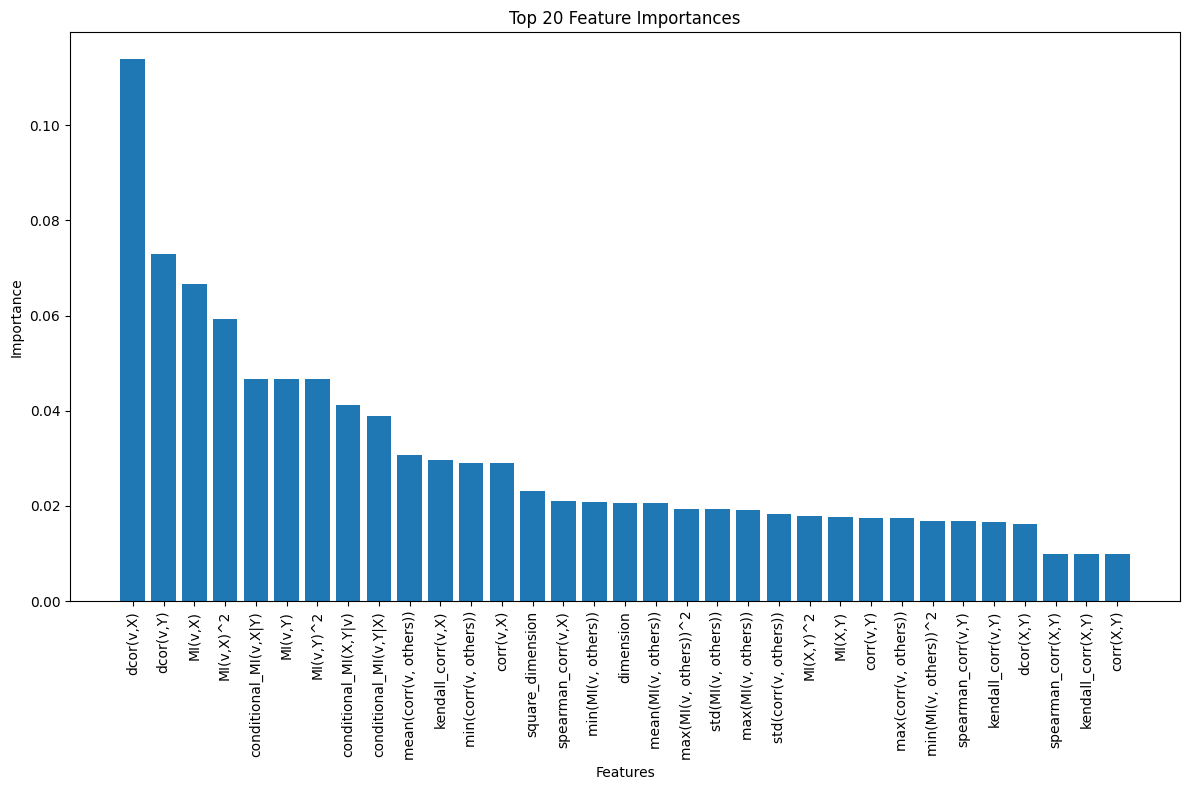

Number of features explaining 90% of the variance: 25


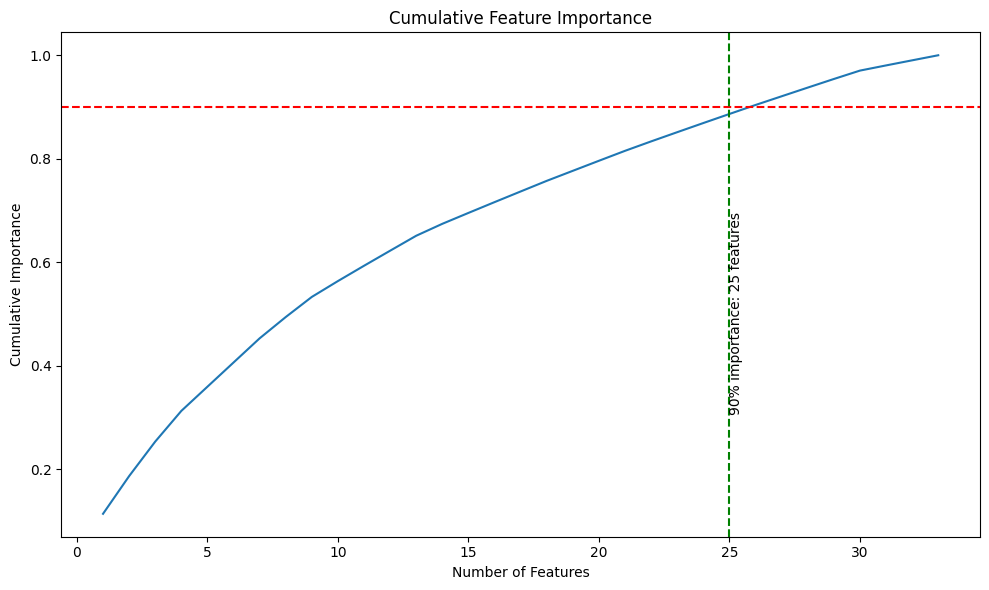

['random_forest_model_v0.joblib']

In [15]:
from matplotlib import pyplot as plt
# 在整个训练集上拟合模型
model.fit(X_train, y_train)

# 获取特征重要性
feature_importance = model.feature_importances_

# 创建一个包含特征名称和重要性分数的DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
})

# 按重要性降序排序
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# 显示前20个最重要的特征
print("Top 20 most important features:")
print(feature_importance_df.head(20))

# 可视化前20个最重要的特征
plt.figure(figsize=(12, 8))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# 计算累积重要性
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()

# 找出解释90%变异的特征数量
features_for_90 = feature_importance_df[feature_importance_df['cumulative_importance'] <= 0.9].shape[0]
print(f"Number of features explaining 90% of the variance: {features_for_90}")

# 可视化累积重要性
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(feature_importance_df) + 1), feature_importance_df['cumulative_importance'])
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.axvline(x=features_for_90, color='g', linestyle='--')
plt.text(features_for_90, 0.5, f'90% importance: {features_for_90} features', rotation=90, va='center')
plt.tight_layout()
plt.show()

# save the model
joblib.dump(model, 'random_forest_model_v0.joblib')


In [16]:
import re

def clean_feature_names(X):
    # 函数用于清理特征名称
    def clean_name(name):
        # 移除或替换特殊字符
        name = re.sub(r'[^\w\s-]', '_', name)
        # 确保名称不以数字开头
        if name[0].isdigit():
            name = 'f_' + name
        return name

    X.columns = [clean_name(col) for col in X.columns]
    return X

# 清理特征名称
X_train = clean_feature_names(X_train)


from lightgbm import LGBMClassifier
import lightgbm as lgb
model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
display(model)

from sklearn.model_selection import GroupKFold
from sklearn.metrics import balanced_accuracy_score
import numpy as np



cv = GroupKFold(n_splits=4)
train_scores = []
val_scores = []

for train_idx, val_idx in cv.split(X_train, y_train, groups=group_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    callbacks = [lgb.log_evaluation(period=1), lgb.early_stopping(stopping_rounds=10)]
    
    model.fit(X_train_fold, y_train_fold, callbacks=callbacks, eval_set=[(X_val_fold, y_val_fold)])

    
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    
    train_score = balanced_accuracy_score(y_train_fold, y_train_pred)
    val_score = balanced_accuracy_score(y_val_fold, y_val_pred)
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    
    print(f"Fold train balanced accuracy: {train_score:.4f}")
    print(f"Fold validation balanced accuracy: {val_score:.4f}")
    print("---")

print(f"Average train balanced accuracy: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
print(f"Average validation balanced accuracy: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, device='gpu',
               gpu_device_id=0, gpu_platform_id=1, learning_rate=0.01,
               max_depth=6, n_estimators=2000, n_jobs=-1, num_leaves=29,
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7914
[LightGBM] [Info] Number of data points in the train set: 107040, number of used features: 32
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (3.27 MB) transferred to GPU in 0.007782 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start 

KeyboardInterrupt: 

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# 假设 X_train, y_train, group_train 已经准备好

# 分割数据集为训练集和验证集
X_train_search, X_val_search, y_train_search, y_val_search, group_train_search, group_val_search = train_test_split(
    X_train, y_train, group_train, test_size=0.2, random_state=42, stratify=y_train
)

# 定义参数搜索空间
param_space = {
    'n_estimators': Integer(800, 1500),
    'learning_rate': Real(0.005, 0.02, prior='log-uniform'),
    'max_depth': Integer(4, 8),
    'num_leaves': Integer(20, 40),
    'min_child_samples': Integer(10, 50),
    'subsample': Real(0.6, 0.9),
    'colsample_bytree': Real(0.6, 0.9),
    'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
    'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    'verbosity': -1, 
}

# 定义基础模型
base_model = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)

# 定义贝叶斯搜索
bayes_search = BayesSearchCV(
    base_model,
    param_space,
    n_iter=50,  # 搜索迭代次数
    cv=[(np.arange(len(X_train_search)), np.arange(len(X_train_search)))],  # 不使用CV
    scoring='balanced_accuracy',
    n_jobs=1,  # 使用GPU时设为1
    verbose=2,
    random_state=42
)

# 执行搜索
bayes_search.fit(
    X_train_search, 
    y_train_search, 
    groups=group_train_search,
    callbacks=[lgb.early_stopping(stopping_rounds=10)],
    eval_set=[(X_val_search, y_val_search)]
)

# 打印最佳参数和分数
print("Best parameters found: ", bayes_search.best_params_)
print("Best score found: ", bayes_search.best_score_)

# 使用最佳参数创建新模型
best_model = LGBMClassifier(
    **bayes_search.best_params_,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)

# 使用交叉验证评估最佳模型
from sklearn.model_selection import GroupKFold
cv = GroupKFold(n_splits=4)
train_scores = []
val_scores = []

for train_idx, val_idx in cv.split(X_train, y_train, groups=group_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    best_model.fit(
        X_train_fold, 
        y_train_fold, 
        callbacks=[lgb.early_stopping(stopping_rounds=10)],
        eval_set=[(X_val_fold, y_val_fold)]
    )
    
    y_train_pred = best_model.predict(X_train_fold)
    y_val_pred = best_model.predict(X_val_fold)
    
    train_score = balanced_accuracy_score(y_train_fold, y_train_pred)
    val_score = balanced_accuracy_score(y_val_fold, y_val_pred)
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    
    print(f"Fold train balanced accuracy: {train_score:.4f}")
    print(f"Fold validation balanced accuracy: {val_score:.4f}")
    print("---")

print(f"Average train balanced accuracy: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
print(f"Average validation balanced accuracy: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4344
[LightGBM] [Info] Number of data points in the train set: 114176, number of used features: 18
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (2.18 MB) transferred to GPU in 0.015417 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] S

KeyboardInterrupt: 

In [17]:
# Uncomment what you need!
def train(
    X_train: typing.Dict[str, pd.DataFrame],
    y_train: typing.Dict[str, pd.DataFrame],
    # number_of_features: int,
    model_directory_path: str,
    # id_column_name: str,
    # prediction_column_name: str,
    # has_gpu: bool,
) -> None:
    # 1) Create the variable embedding:
    return
    X_y_group_train_pathname = "/tmp/X_y_group_train.parquet"
    try:
        print(f"Loading {X_y_group_train_pathname}")
        X_y_group_train = pd.read_parquet(X_y_group_train_pathname)
    except FileNotFoundError:
        print("Creating X_y_group_train")
        names_datasets_train = X_train
        names_graphs_train = y_train
        X_y_group_train = create_all_columns(
            {
                pearson_correlation: names_datasets_train,
                ttest: names_datasets_train,
                mutual_information: names_datasets_train,  # comment this line to greatly reduce computation
                label: names_graphs_train,
                spearman_correlation: names_datasets_train,
                kendall_correlation: names_datasets_train,
                distance_correlation: names_datasets_train,
                conditional_mutual_information: names_datasets_train,
            },
            n_jobs=-1,
        )
        X_y_group_train = remove_outliers(X_y_group_train, ['corr(v,X)', 'corr(v,Y)', 'ttest(v,X)', 'ttest(v,Y)'])
        # 2) Massage X_y_group_train to prepare what is needed by the model:
        print("Adding numeric labels y") # sklearn wants numeric labels
        le = LabelEncoder()
        le.classes_ = np.array([
            'Cause of X', 'Consequence of X', 'Confounder', 'Collider',
            'Mediator', 'Independent', 'Cause of Y', 'Consequence of Y',
        ])
        X_y_group_train["y"] = le.transform(X_y_group_train["label"])

        # reordering columns:
        X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]
        display(X_y_group_train)

        print("Saving X_y_group_train")
        os.makedirs(os.path.dirname(X_y_group_train_pathname), exist_ok=True)
        X_y_group_train.to_parquet(X_y_group_train_pathname)

    print("Extracting X_train, y_train, and group")
    X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")
    y_train = X_y_group_train["y"]
    group_train = X_y_group_train["dataset"]

    # Model:
    model = RandomForestClassifier(n_estimators=100, max_depth=11, n_jobs=-1, class_weight="balanced")
    model.fit(X_train, y_train)

    joblib.dump(
        model,
        os.path.join(model_directory_path, "model.joblib")
    )


In [20]:
def create_submission(X_y_pred_test):
    """
    From the predicted test set, for each dataset, take predicted
    classes of all variables, create the adjacency matrix, then create
    the submission in the requested format.
    """

    submission = {}
    for name, prediction in tqdm(X_y_pred_test.groupby("dataset"), delay=10):
        variables_labels = prediction[["variable", "label_predicted"]].set_index("variable")
        variables = variables_labels.index.tolist()
        variables_all = ["X", "Y"] + variables

        adjacency_matrix = pd.DataFrame(index=variables_all, columns=variables_all)
        adjacency_matrix.index.name = "parent"
        adjacency_matrix[:] = 0
        adjacency_matrix.loc["X", "Y"] = 1

        for v in variables:
            l = variables_labels.loc[v].item()
            if l == "Cause of X":
                adjacency_matrix.loc[v, "X"] = 1
            elif l == "Cause of Y":
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Consequence of X":
                adjacency_matrix.loc["X", v] = 1
            elif l == "Consequence of Y":
                adjacency_matrix.loc["Y", v] = 1
            elif l == "Confounder":
                adjacency_matrix.loc[v, "X"] = 1
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Collider":
                adjacency_matrix.loc["X", v] = 1
                adjacency_matrix.loc["Y", v] = 1
            elif l == "Mediator":
                adjacency_matrix.loc["X", v] = 1
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Confounder":
                pass

        for i in variables_all:
            for j in variables_all:
                submission[f'{name}_{i}_{j}'] = int(adjacency_matrix.loc[i, j])

    return submission


# Uncomment what you need!
def infer(
    X_test: typing.Dict[str, pd.DataFrame],
    # number_of_features: int,
    model_directory_path: str,
    id_column_name: str,
    prediction_column_name: str,
    # has_gpu: bool,
    # has_trained: bool,
) -> pd.DataFrame:
    model = joblib.load(os.path.join(model_directory_path, "random_forest_model_v0.joblib"))

    names_datasets_test = X_test
    X_group_test = create_all_columns(
        {
                pearson_correlation: names_datasets_train,
                ttest: names_datasets_train,
                mutual_information: names_datasets_train,  # comment this line to greatly reduce computation
                label: names_graphs_train,
                spearman_correlation: names_datasets_train,
                kendall_correlation: names_datasets_train,
                distance_correlation: names_datasets_train,
                conditional_mutual_information: names_datasets_train,
        },
        n_jobs=-1,
    )

    X_test = X_group_test.drop(columns=["dataset", "variable"])
    y_predicted = model.predict(X_test)
    X_y_pred_test = X_group_test
    X_y_pred_test["y_predicted"] = y_predicted

    le = LabelEncoder()
    le.classes_ = np.array([
        'Cause of X', 'Consequence of X', 'Confounder', 'Collider',
        'Mediator', 'Independent', 'Cause of Y', 'Consequence of Y',
    ])

    X_y_pred_test["label_predicted"] = le.inverse_transform(y_predicted)

    submission = create_submission(X_y_pred_test)

    return pd.DataFrame(
        submission.items(),
        columns=[
            id_column_name,
            prediction_column_name
        ]
    )

In [21]:
crunch.test(
    no_determinism_check=True
)

print("Download this notebook and submit it to the platform: https://hub.crunchdao.com/competitions/causality-discovery/submit/via/notebook")

12:53:24 no forbidden library found
12:53:24 
12:53:24 started
12:53:24 running local test
12:53:24 internet access isn't restricted, no check will be done
12:53:24 
12:53:31 starting dag process...


download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


12:53:42 call: train
12:53:42 call: infer
12:53:43 duration - time=00:00:19
12:53:43 memory - before="2.54 GB" after="3.52 GB" consumed="1,001.20 MB"


NameError: name 'names_datasets_train' is not defined